In [2]:
%matplotlib notebook
import cameratransform as ct
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

### Import calibration image for camera 1 (1280x960 resolution) and undistort
I'm fairly sure that the camera matrix for this resolution has the wrong optical centre, as it is very similar to the 640x480 resolution. Assuming that the optical centre should be in the centre of the image, so am multiplying the values in the matrix by 2 so that the pixel coordinate is roughly in the centre of the image.

<IPython.core.display.Javascript object>


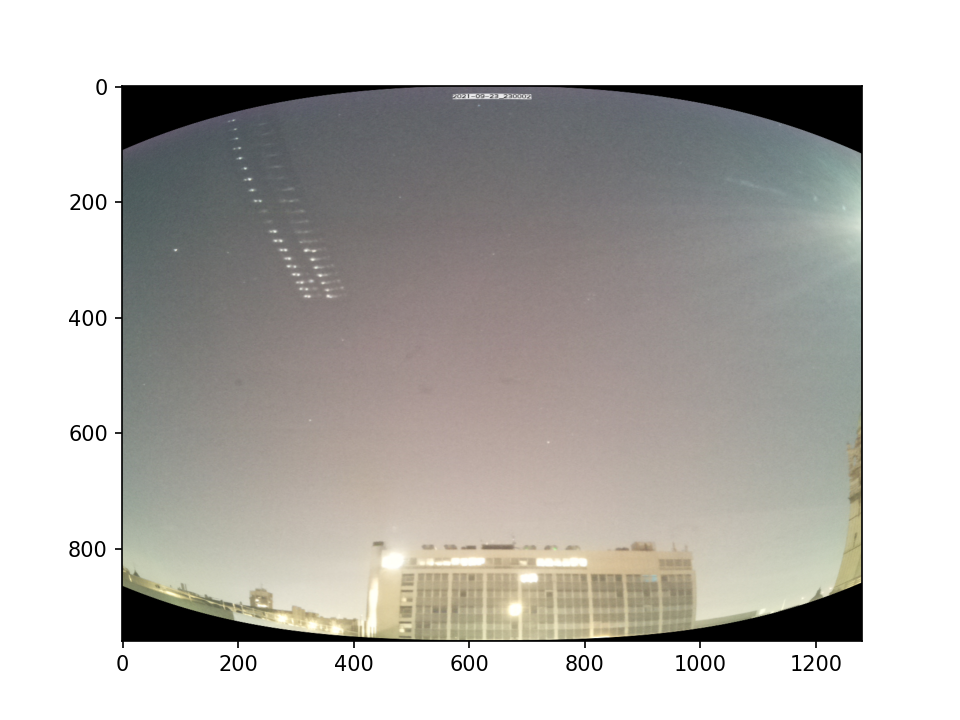

In [6]:
camM = np.array([[5.063166013857816665e+02,0.000000000000000000e+00,2*3.166661931952413056e+02],
                [0.000000000000000000e+00,5.067357512519903935e+02,2*2.526423174030390157e+02],
                [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])
distortion = np.array([2.326755157584974587e-01,-6.011054678561147391e-01,3.963575587693899294e-04,-2.566491984608918874e-04,4.822591716560123420e-01])
w, h = 1280, 960

filepath = r"C:/Users/kathe/OneDrive - Imperial College London\MSci Project/longExposures/"
filename = f'tl_2021-09-23_230002_CAL1.jpg'

im = plt.imread(filepath+filename)

new_camM, roi = cv.getOptimalNewCameraMatrix(camM,distortion,(w,h),1,(w,h))

im_undistorted = cv.undistort(im, camM, distortion, None, new_camM)
fig, ax = plt.subplots(1,1)
ax.imshow(im_undistorted)

#plt.savefig('calib_undistorted_1280x960.png', bbox_inches='tight')

### Resize image to 640x480 to find pixel coordinates in lower resolution

i.e. undistort image using the camera matrix and distortion coefficients for the lower resolution

<IPython.core.display.Javascript object>


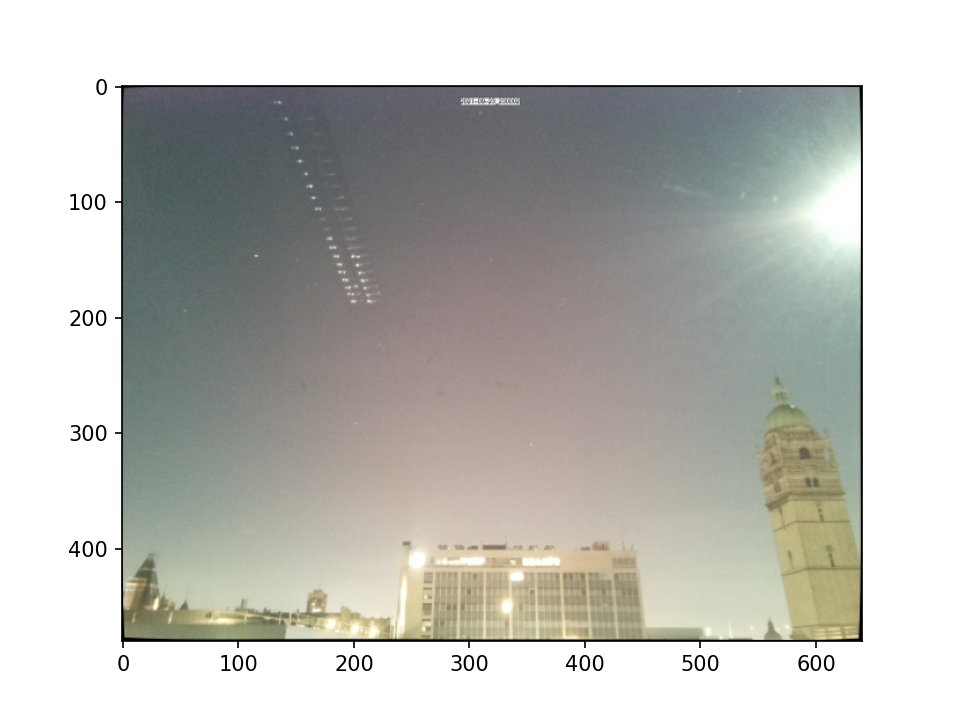

In [7]:
im_low_res = cv.resize(im,(640,480),fx=0,fy=0, interpolation = cv.INTER_CUBIC)
w1,h1 = 640,480

camM_low_res = np.array([[5.520688775958645920e+02,0.000000000000000000e+00,3.225866125962970159e+02],
          [0.000000000000000000e+00,5.502640890663026312e+02,2.362389385357402034e+02],
          [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])
distortion_low_res = np.array([2.808374038768443048e-01,-9.909134707088265159e-01,6.299531255281858727e-04,-1.301770463801651002e-03,1.093982545460403522e+00])

new_camM_low_res, roi = cv.getOptimalNewCameraMatrix(camM_low_res,distortion_low_res,(w1,h1),1,(w1,h1))

im_undistorted_low_res = cv.undistort(im_low_res, camM_low_res, distortion_low_res, None, new_camM_low_res)
fig, ax = plt.subplots(1,1)
ax.imshow(im_undistorted_low_res)

#plt.savefig('calib_undistorted_640x480.png', bbox_inches='tight')

In [13]:
# intrinsic camera parameters
f_mm = 3.04    # in mm
pixel_size = 1.12e-3 # length of one side of square pixel in mm
sensor_size = (3.68, 2.76) # in mm
image_size = (1280, 960)    # in px
image_size_lowres = (640, 480) #in 
f_x_px = (f_mm /sensor_size[0]) * image_size[0] #focal length relative to pixel width
f_y_px = (f_mm /sensor_size[1]) * image_size[1] #focallength relative to pixel height


# initialize the camera
# camera is using the original 1280x960 image without any undistortion
# camera2 is using the undistorted 640x480 image
# camera3 is using the undistorted 1280x960 image
camera = ct.Camera(ct.RectilinearProjection(focallength_x_px = f_x_px, focallength_y_px = f_y_px, image = im))
camera2 = ct.Camera(ct.RectilinearProjection(focallength_px = f_mm/pixel_size, image = im_undistorted_low_res))
camera3 = ct.Camera(ct.RectilinearProjection(focallength_px = f_mm/pixel_size, image = im_undistorted))

camera.setGPSpos(51.49880908055068, -0.1788492157810761, 30)
camera2.setGPSpos(51.49880908055068, -0.1788492157810761, 30)
camera3.setGPSpos(51.49880908055068, -0.1788492157810761, 30)

lm_points_px = np.array([[1135.4,503.9], [342,863.3], [1122,922.83]]) #queens tower, peninsula tower, brompton oratory
lm_points_px_1280 = np.array([[241.1,859.8], [1208.0,863.6]]) #peninsula tower, brompton oratory
lm_points_px_640 = np.array([[565.0,247.82], [170.45,429.91],[559.10,457.74]])
lm_points_gps = np.array([[51.498342738054035, -0.1768382060138951, 87], 
                          [51.502, -0.167, 94], 
                          [51.49723597996239, -0.1696021165279743, 61]])
lm_points_space = camera.spaceFromGPS(lm_points_gps)
lm_points_space_640 = camera2.spaceFromGPS(lm_points_gps)
lm_points_space_1280 = camera3.spaceFromGPS(lm_points_gps)

camera.addLandmarkInformation(lm_points_px[1:, :], lm_points_space[1:, :], [3, 3, 5]) #last argument is the uncertainty in each gps coordinate
camera2.addLandmarkInformation(lm_points_px_640[1:, :], lm_points_space_640[1:, :], [3, 3, 5])
camera3.addLandmarkInformation(lm_points_px_1280, lm_points_space_1280[1:, :], [3, 3, 5])

In [17]:
# find trace through the parameter space
trace = camera.metropolis([
        ct.FitParameter("elevation_m", lower=29, upper=31, value=30),
        ct.FitParameter("tilt_deg", lower=0, upper=180, value=90),
        ct.FitParameter("heading_deg", lower=-180, upper=180, value=90),
        ct.FitParameter("roll_deg", lower=-20, upper=20, value=-0.6)
        ], iterations=1e4)

100%|██████████| 10000/10000 [01:23<00:00, 119.81it/s, acc_rate=0.176, factor=0.0164]


      elevation_m    tilt_deg  heading_deg  roll_deg   probability
0       29.932834  114.721086    80.929349  2.499399 -20634.693606
1       29.932834  114.721086    80.929349  2.499399 -20634.693606
2       29.932834  114.721086    80.929349  2.499399 -20634.693606
3       29.932834  114.721086    80.929349  2.499399 -20634.693606
4       29.932834  114.721086    80.929349  2.499399 -20634.693606
...           ...         ...          ...       ...           ...
8994    29.894558  114.754471    80.888807  2.589696 -20636.039925
8995    29.887643  114.749774    80.893014  2.580876 -20634.137185
8996    29.887643  114.749774    80.893014  2.580876 -20634.137185
8997    29.887643  114.749774    80.893014  2.580876 -20634.137185
8998    29.887643  114.749774    80.893014  2.580876 -20634.137185

[8999 rows x 5 columns]


<IPython.core.display.Javascript object>


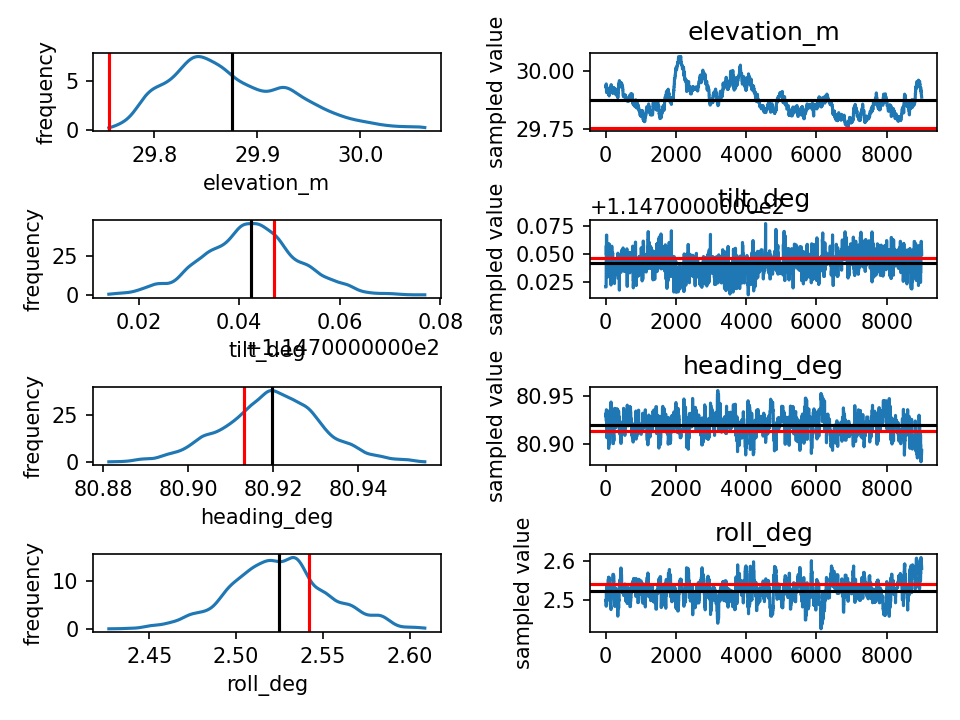

In [20]:
# plot trace through parameter space
plt.figure()
camera.plotTrace()
plt.tight_layout()
#plt.savefig('1280x640_undistorted_trace.png', bbox_inches='tight')

<IPython.core.display.Javascript object>


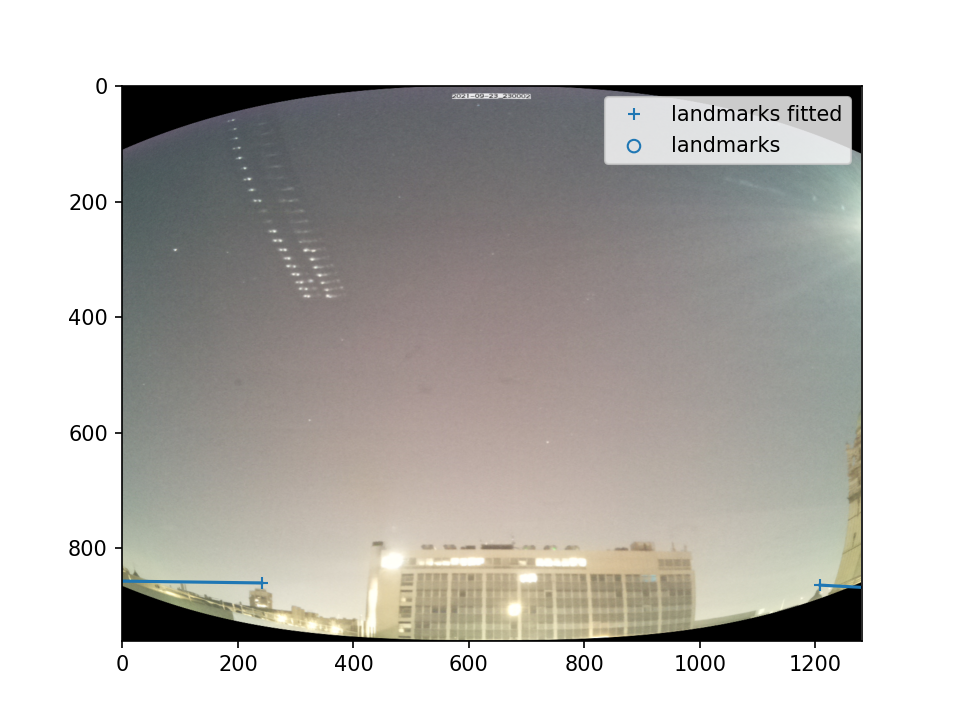

In [53]:
# plot fitted positions of landmarks on image
plt.figure()
camera3.plotFitInformation(im_undistorted)
plt.legend();
#plt.savefig('fittedLandmarks.png', bbox_inches='tight')

In [55]:
trace_array = trace.to_numpy()
elevation_m = trace_array[-1,0]
tilt_deg = trace_array[-1,1]
heading_deg =trace_array[-1,2]
roll_deg = trace_array[-1,3]
prob = trace_array[-1,4]

# Camera 3
### Now repeat process for camera 3:

- Import calibration image
- Undistort
- Create camera object
- search parameter space for best fitting orientation

<IPython.core.display.Javascript object>


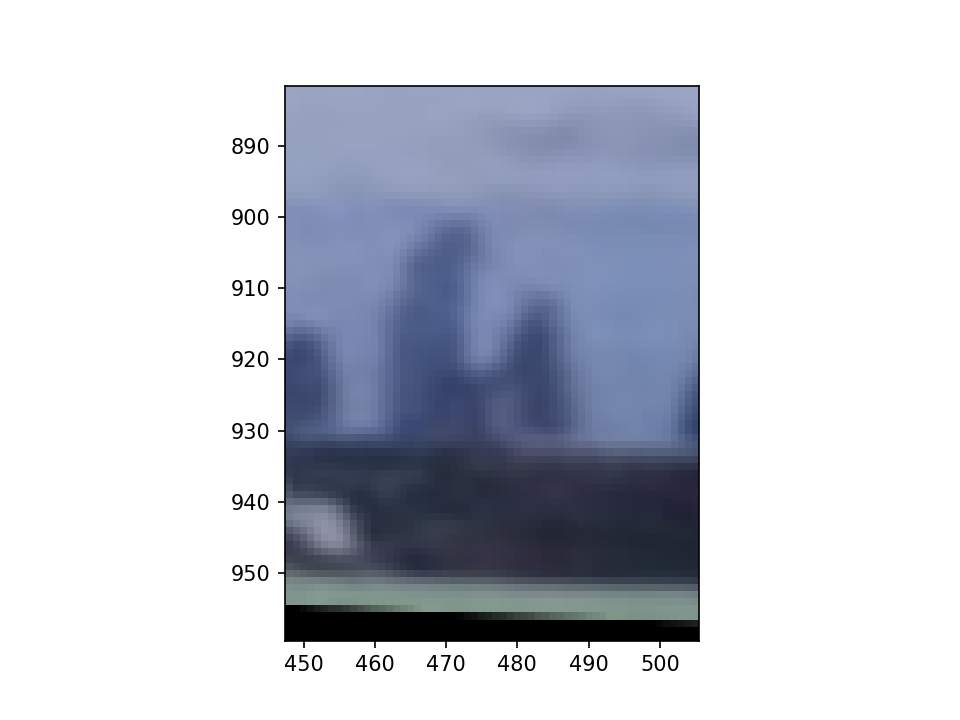

In [22]:
camM = np.array([[5.063166013857816665e+02,0.000000000000000000e+00,2*3.166661931952413056e+02],
                [0.000000000000000000e+00,5.067357512519903935e+02,2*2.526423174030390157e+02],
                [0.000000000000000000e+00,0.000000000000000000e+00,1.000000000000000000e+00]])
distortion = np.array([2.326755157584974587e-01,-6.011054678561147391e-01,3.963575587693899294e-04,-2.566491984608918874e-04,4.822591716560123420e-01])
w, h = 1280, 960

#filepath = r"C:/Users/kathe/OneDrive - Imperial College London\MSci Project/longExposures/"
#filename = f'tl4_2021-09-23_230002_CAL1.jpg'
filepath = "C:/Users/kathe/OneDrive - Imperial College London/MSci Project/output_C3/"
filename = "C3_031021_frame_14.jpg"

im = plt.imread(filepath+filename)
im_big = cv.resize(im,(1280,960),fx=0,fy=0, interpolation = cv.INTER_CUBIC)

new_camM, roi = cv.getOptimalNewCameraMatrix(camM,distortion,(w,h),1,(w,h))

im_undistorted = cv.undistort(im_big, camM, distortion, None, new_camM)
fig, ax = plt.subplots(1,1)
ax.imshow(im_undistorted)

#plt.savefig('calib_C3_undistorted_1280x960.png', bbox_inches='tight')

In [31]:
# intrinsic camera parameters
f_mm = 3.04    # in mm
pixel_size = 1.12e-3 # length of one side of square pixel in mm
sensor_size = (3.68, 2.76) # in mm
image_size = (1280, 960)    # in px
f_x_px = (f_mm /sensor_size[0]) * image_size[0] #focal length relative to pixel width
f_y_px = (f_mm /sensor_size[1]) * image_size[1] #focallength relative to pixel height

camera = ct.Camera(ct.RectilinearProjection(focallength_x_px = f_x_px, focallength_y_px = f_y_px, image = im_undistorted))

camera.setGPSpos(51.4993318750954, -0.17901837289811393, 46)

lm_points_px_1280 = np.array([[338.96,839.97],[708.53,897.53], [483.6,909.8], [506.03, 916.6], [472.0,899.3]]) #peninsula, shard, RCM, cheesegrater, scalpel, 22 bishops 
lm_points_gps = np.array([[51.502, -0.167, 94], [51.504570716500965, -0.08649973661973948, 326], 
                          [51.514199912543596, -0.082157669459782, 266], [51.51327187191974, -0.08132082019621222, 232], [ 51.51438883427781, -0.08297279981969655, 315]])
#height of rcm tower estimated with google earth
lm_points_space = camera.spaceFromGPS(lm_points_gps)

camera.addLandmarkInformation(lm_points_px_1280, lm_points_space, [3, 3, 20]) #last argument is the uncertainty in each gps coordinate

In [32]:
# find trace through the parameter space
trace = camera.metropolis([
        #ct.FitParameter("elevation_m", lower=44, upper=48, value=45),
        ct.FitParameter("tilt_deg", lower=0, upper=180, value=90),
        ct.FitParameter("heading_deg", lower=0, upper=360, value=90),
        ct.FitParameter("roll_deg", lower=-20, upper=20, value=0)
        ], iterations=1e4)

100%|██████████| 10000/10000 [01:31<00:00, 109.22it/s, acc_rate=0.0316, factor=0.00738]

        tilt_deg  heading_deg   roll_deg   probability
0     110.848736    90.386876 -19.830669 -3.105635e+06
1     110.848736    90.386876 -19.830669 -3.105635e+06
2     110.848736    90.386876 -19.830669 -3.105635e+06
3     110.848736    90.386876 -19.830669 -3.105635e+06
4     110.848736    90.386876 -19.830669 -3.105635e+06
...          ...          ...        ...           ...
8994  110.864256    90.423041 -19.934444 -3.094252e+06
8995  110.864256    90.423041 -19.934444 -3.094252e+06
8996  110.864256    90.423041 -19.934444 -3.094252e+06
8997  110.864256    90.423041 -19.934444 -3.094252e+06
8998  110.847355    90.425038 -19.934881 -3.094237e+06

[8999 rows x 4 columns]


<IPython.core.display.Javascript object>


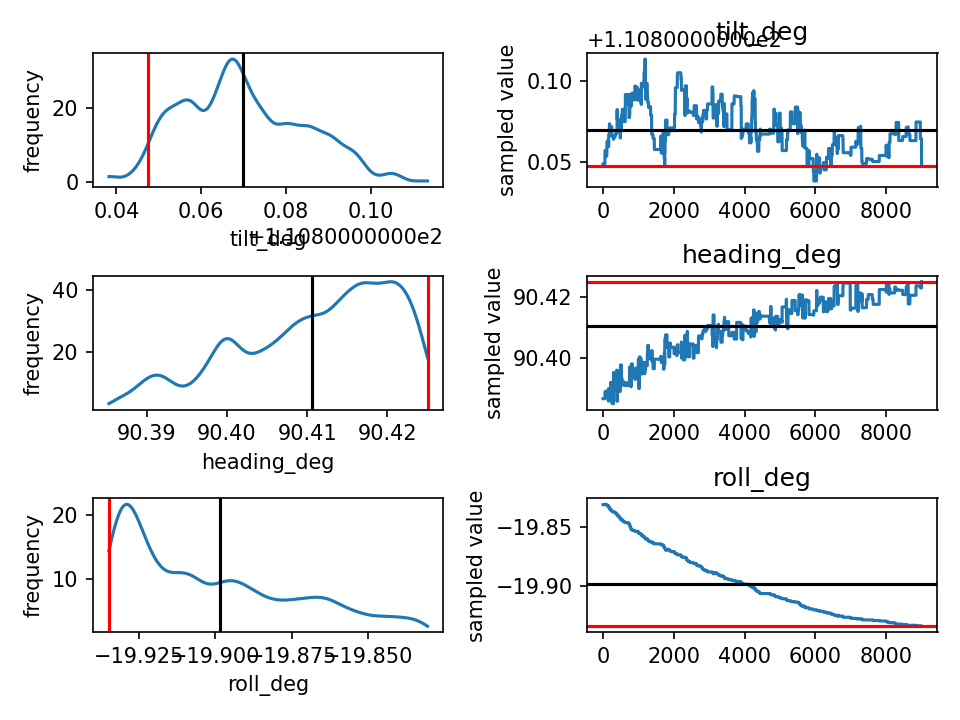

In [33]:
# plot trace through parameter space
plt.figure()
camera.plotTrace()
plt.tight_layout()
#plt.savefig('1280x640_C3_undistorted_trace.png', bbox_inches='tight')

### Try stereo functionality from cameratransform:

probably not actually that necessary because it's just reproducing things we've already done?

<IPython.core.display.Javascript object>


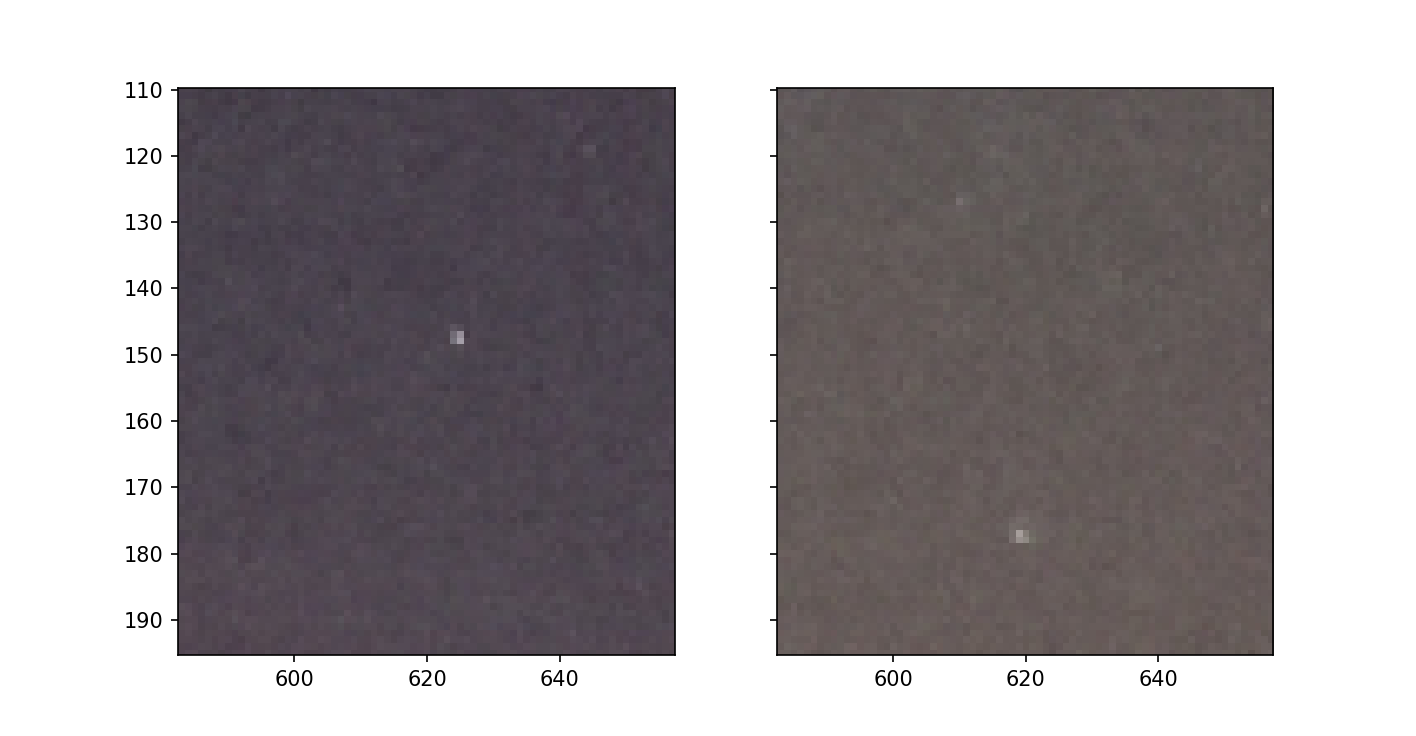

In [18]:
filepath = r"C:/Users/kathe/OneDrive - Imperial College London\MSci Project/longExposures/"
filenameL = f'tl4_2021-10-30_230002_CAL1.jpg'
filenameR = f'tl_2021-10-30_230002_CAL1.jpg'
imL = plt.imread(filepath+filenameL)
imR = plt.imread(filepath+filenameR)

translation_vector = np.array([ 61.09920255, -16.,   0.])
fig, (ax1, ax2) = plt.subplots(1,2, sharex=True, sharey=True)
ax1.imshow(imL)
ax2.imshow(imR)

In [13]:
camL = ct.Camera(ct.RectilinearProjection(focallength_px = f/pixel_size, image = [1280, 960]))
camR = ct.Camera(camL.projection)

cam_group = ct.CameraGroup(camL.projection, (camL.orientation, camR.orientation))

In [21]:
baseline = translation_vector[0] #in m?

In [23]:
# initial guess of the two camera parameters
camL.tilt_deg = 90
camL.heading_deg = 100
camL.roll_deg = 0
camL.pos_x_m = 0
camL.pos_y_m = 0
camL.elevation_m = 46

camR.tilt_deg = 102.635192
camR.heading_deg = 80.702934
camR.roll_deg = 0
camR.pos_x_m = -baseline
camR.pos_y_m = -16
camR.elevation_m = 30

In [25]:
#point correspondences (in this case these are coordinates of stars)

corresponding1 = np.array([[1181, 418], [1085.1,406.6], [1046.9,510.6], [1266.4,536], [1264.5,565.3], [1258.1,592.8], [432.6,465], [441,545.6], [835.7,145.1], [624.8,147.3]]) 
corresponding2 = np.array([[1186,436.8], [1088.8,427.8], [1056.7,533.2], [1277,556.6], [1276.1,586.2], [1270.9,614.9], [429.4,495.1], [438.2,576], [828.9,171.9], [618.9,177.2]])

cam_group.addPointCorrespondenceInformation(corresponding1, corresponding2)

trace = cam_group.metropolis([
        ct.FitParameter("CL_heading_deg", lower=60, upper=120, value=90),
        ct.FitParameter("CL_roll_deg", lower=-5, upper=5, value=0),
        ct.FitParameter("CR_tilt_deg", lower=45, upper=135, value=85),
        ct.FitParameter("CR_heading_deg", lower=60, upper=120, value=90),
        ct.FitParameter("CR_roll_deg", lower=-5, upper=5, value=0)
    ], iterations=1e4)

ValueError: Could not find a starting position with non-zero probability.